In [111]:
# !unzip '/content/drive/MyDrive/crim.zip' -d '/content/drive/MyDrive/data/'

라이브러리 로드

In [112]:
import pandas as pd
import numpy as np
import seaborn as sns
pd.options.display.max_columns = None

In [113]:
train_df = pd.read_csv('/content/drive/MyDrive/data/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/data/test.csv')
np.unique( train_df['월']), np.unique( test_df['월'])

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]))

한글처리

In [114]:
!sudo apt-get install -y fonts-nanum
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fm.fontManager.addfont("/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf")
plt.rcParams['font.family'] = "NanumBarunGothic"

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20180306-3).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.


이상치 탐색
  - 날씨와 관련된 데이터가 있고 해당 날씨는 특정 달에 편차가 심하므로 이상치로 보지 않고 하나의 특성으로 본다
  - 이상치 제거는 하지 않은 것으로 결론
  - 이상치에 해당하는 데이터는 2월에 집중되어 있음 
  - 강수량 적설량 강설량과 범죄와의 상관관계가 있는지 조사하고 없으면 해당 컬럼을 제거해도 무방할 것 같음
  - 일단 1차로 모든 데이터를 사용할 것임

In [115]:
train_df.loc[:,'소관경찰서':'범죄발생지'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84406 entries, 0 to 84405
Data columns (total 15 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   소관경찰서    84406 non-null  int64  
 1   소관지역     84406 non-null  float64
 2   사건발생거리   84406 non-null  float64
 3   강수량(mm)  84406 non-null  float64
 4   강설량(mm)  84406 non-null  float64
 5   적설량(cm)  84406 non-null  float64
 6   풍향       84406 non-null  float64
 7   안개       84406 non-null  float64
 8   짙은안개     84406 non-null  float64
 9   번개       84406 non-null  float64
 10  진눈깨비     84406 non-null  float64
 11  서리       84406 non-null  float64
 12  연기/연무    84406 non-null  float64
 13  눈날림      84406 non-null  float64
 14  범죄발생지    84406 non-null  object 
dtypes: float64(13), int64(1), object(1)
memory usage: 9.7+ MB


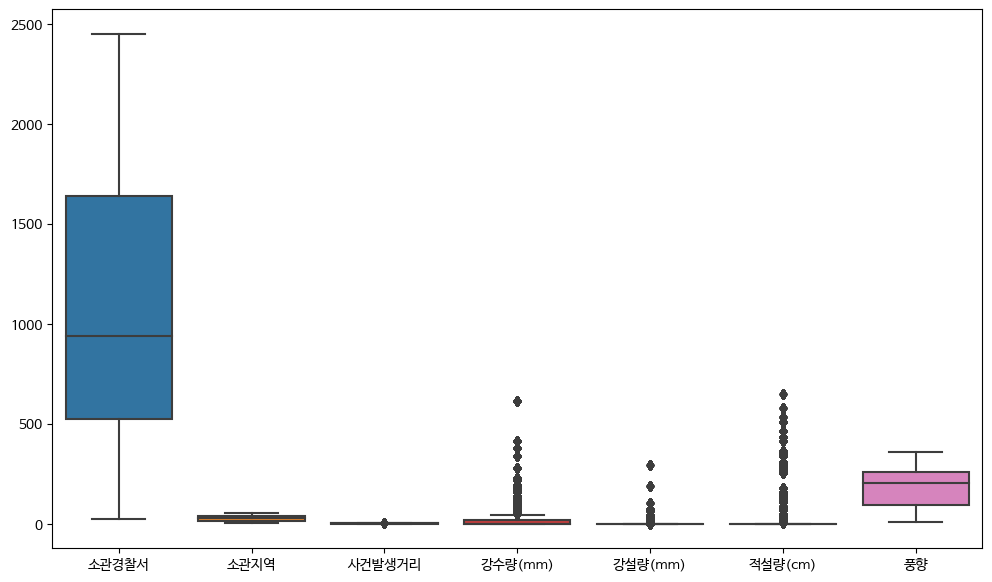

In [116]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,7))
sns.boxplot(train_df.loc[:,'소관경찰서':'풍향'])
plt.show()

In [117]:
def removeOutLier(df = train_df,display=False):
  temp = df.loc[:,'강수량(mm)':'적설량(cm)']
  q1 = temp.quantile(0.25)
  q3 = temp.quantile(0.75)
  IQR = q3 - q1
  IQR     
  iqr_index = temp[((temp<(q1-1.5*IQR)) | (temp > (q3 + 1.5*IQR))).any(axis=1)].index
  df = df.drop(iqr_index)
  
  if display : 
    plt.figure(figsize=(12,5))
    sns.boxplot(df.loc[:,'강수량(mm)':'적설량(cm)'])
    plt.xticks(rotation = 45)
    plt.show()
  return df
# train_df_iqr =  removeOutLier() 
# test_df_iqr =  removeOutLier(test_df) 
# print(train_df_iqr.shape, test_df_iqr.shape)
# # 트레인 데이터는 타겟이 있어서 컬럼수가 다르다
# # 범주형 데이터의 개수가 맞는지 확인한다.
# np.unique( test_df_iqr['월'])

oneHotEncoding : 월,	요일,	시간, 범죄발생지

스케일링 : 소관경찰서,	소관지역,	사건발생거리,	강수량(mm),	강설량(mm)	,적설량(cm),	풍향

binary data : 안개,	짙은안개,	번개,	진눈깨비,	서리,	연기/연무,	눈날림

In [118]:
def makeOneHot(df):
  pd_oneHot =  pd.concat([ pd.get_dummies(df['월'],prefix='월').reset_index(drop=True),
                          pd.get_dummies(df['요일'],prefix='요일').reset_index(drop=True),
                          pd.get_dummies(df['시간'],prefix='시간').reset_index(drop=True),
                          pd.get_dummies(df['범죄발생지'],prefix='범죄발생지').reset_index(drop=True)
                    ],axis=1)
  return pd_oneHot
# 불필요한 컬럼은 제거한다.
trainX = train_df.iloc[:,1:-1]
y = train_df.iloc[:,-1]

testX =  test_df.iloc[:,1:]
print(trainX.shape, testX.shape)

train_oneHot = makeOneHot(trainX)
test_oneHot = makeOneHot(testX)
print(train_oneHot.shape, test_oneHot.shape)

(84406, 18) (17289, 18)
(84406, 45) (17289, 45)


In [119]:
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import RobustScaler
def scalingData(scaler,data):  
  scaler.fit( train_df.loc[:,'소관경찰서':'풍향'] )  #train test 상관없이 학습기준이 되는 train으로 스케일링 규칙을 정한다
  scaled_data = scaler.transform(data.loc[:,'소관경찰서':'풍향'] )
  return pd.DataFrame(scaled_data, columns=data.loc[:,'소관경찰서':'풍향'].columns)

In [120]:
rs = RobustScaler()
train_df_scaled = scalingData(rs,train_df)
test_df_scaled = scalingData(rs,test_df)
train_df_scaled.shape, test_df_scaled.shape

((84406, 7), (17289, 7))

oneHotEncoding + 스케일링 + binary data

In [121]:
train = pd.concat( [train_oneHot, train_df_scaled, train_df.loc[:,'안개':'눈날림'].reset_index(drop=True)]  ,axis=1)
test = pd.concat( [test_oneHot, test_df_scaled, test_df.loc[:,'안개':'눈날림'].reset_index(drop=True)]  ,axis=1)
train.shape, test.shape

((84406, 59), (17289, 59))

In [122]:
!pip install efficientnet_pytorch
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


머신러닝 모델을 리스트에 저장해서 교차검증을 통한 성능 비교 및 모델 선택하기(데이터는 정규화 되어 있음)

In [123]:
import sklearn 
from sklearn.neighbors import KNeighborsClassifier #Classifier implementing the k-nearest neighbors vote
from sklearn.tree import DecisionTreeClassifier## is a class capable of performing multiclass classification on a dataset.
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier#Iteratively trains because at each time step the partial derivatives of the loss function with respect to the model parameters are computed. 
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.mixture import BayesianGaussianMixture
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
import lightgbm as ltb
import xgboost as xgb
import catboost as cb
from sklearn.ensemble import GradientBoostingClassifier
from efficientnet_pytorch import EfficientNet
# 교차 검증
from sklearn.model_selection import cross_validate
# 특성을 추가하여 비 선형으로 만들기
from sklearn.preprocessing import PolynomialFeatures

In [124]:
#create List models 
models = []
models.append(('KNN', KNeighborsClassifier()))
# models.append(('SVM', SVC()))
models.append(('DecisionTreeClassifier', DecisionTreeClassifier()))
models.append(('LogisticRegression', LogisticRegression(max_iter=1000)))
# models.append(('LinearDiscriminantAnalysis', LinearDiscriminantAnalysis()))
# models.append(('GaussianNB', GaussianNB()))
models.append(('MLPClassifier', MLPClassifier()))
# models.append(('BayesianGaussianMixture', BayesianGaussianMixture()))
models.append(('SGDClassifier', SGDClassifier()))
models.append(('RandomForestClassifier', RandomForestClassifier()))
models.append(('GradientBoostingClassifier', GradientBoostingClassifier()))

models.append(('LGBMClassifier', ltb.LGBMClassifier()))
models.append(('XGBClassifier', xgb.XGBClassifier()))
models.append(('CatBoostClassifier', cb.CatBoostClassifier()))


In [125]:
# calculate accuracy
from sklearn.model_selection import train_test_split , cross_val_score,KFold,GridSearchCV
scoring_=[]
name_m=[]
from tqdm import tqdm
for i in  tqdm(range(len(models))):
    kfold = KFold(n_splits=5, shuffle=True, random_state=43)
    scor = cross_val_score(models[i][1], train, y, cv=kfold, scoring='accuracy')  
    scoring_.append(scor)
    name_m.append(models[i][0])
    print("{} : score {:.3f} ".format(models[i][0]  , np.mean(scoring_)  ))

 10%|█         | 1/10 [01:11<10:40, 71.19s/it]

KNN : score 0.456 


 20%|██        | 2/10 [01:19<04:31, 34.00s/it]

DecisionTreeClassifier : score 0.447 


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

LogisticRegression : score 0.475 


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptro

MLPClassifier : score 0.486 


 50%|█████     | 5/10 [21:07<24:57, 299.53s/it]

SGDClassifier : score 0.486 


 60%|██████    | 6/10 [22:50<15:30, 232.64s/it]

RandomForestClassifier : score 0.492 


 70%|███████   | 7/10 [27:38<12:32, 250.91s/it]

GradientBoostingClassifier : score 0.500 


 80%|████████  | 8/10 [28:12<06:03, 181.81s/it]

LGBMClassifier : score 0.506 


 90%|█████████ | 9/10 [34:05<03:55, 235.18s/it]

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
4:	learn: 1.0282844	total: 183ms	remaining: 36.5s
5:	learn: 1.0208427	total: 216ms	remaining: 35.8s
6:	learn: 1.0142900	total: 260ms	remaining: 36.9s
7:	learn: 1.0091876	total: 306ms	remaining: 37.9s
8:	learn: 1.0049341	total: 343ms	remaining: 37.8s
9:	learn: 1.0011221	total: 379ms	remaining: 37.5s
10:	learn: 0.9977776	total: 411ms	remaining: 37s
11:	learn: 0.9950174	total: 443ms	remaining: 36.4s
12:	learn: 0.9923806	total: 480ms	remaining: 36.5s
13:	learn: 0.9902497	total: 510ms	remaining: 35.9s
14:	learn: 0.9884813	total: 544ms	remaining: 35.7s
15:	learn: 0.9871934	total: 579ms	remaining: 35.6s
16:	learn: 0.9857426	total: 608ms	remaining: 35.1s
17:	learn: 0.9843914	total: 643ms	remaining: 35.1s
18:	learn: 0.9831388	total: 673ms	remaining: 34.7s
19:	learn: 0.9820051	total: 725ms	remaining: 35.5s
20:	learn: 0.9810836	total: 758ms	remaining: 35.3s
21:	learn: 0.9802243	total: 787ms	remaining: 35s
22:	learn: 0.9795592	total: 821ms	remaining: 34.9s
23:	l

100%|██████████| 10/10 [37:51<00:00, 227.13s/it]

CatBoostClassifier : score 0.514 


In [134]:
mlp = MLPClassifier(max_iter=1000,early_stopping=True,n_iter_no_change=10,learning_rate='invscaling',solver ='adam')
kfold = KFold(n_splits=5, shuffle=True, random_state=43)
scor = cross_val_score(mlp, train, y, cv=kfold, scoring='accuracy')

array([0.54045729, 0.53255139, 0.53130739, 0.53243291, 0.53266987])

In [135]:
np.mean(scor)

0.5338837692400713

In [136]:
logistic_lr = LogisticRegression(max_iter=1000,solver = 'liblinear')
kfold = KFold(n_splits=5, shuffle=True, random_state=43)
scor = cross_val_score(logistic_lr, train, y, cv=kfold, scoring='accuracy')

In [137]:
np.mean(scor)

0.5325805766325097

In [138]:
np.mean(scoring_,axis=1)

array([0.45592729, 0.43764658, 0.53250949, 0.51608883, 0.48962146,
       0.51800815, 0.54733068, 0.54964093, 0.54711743, 0.54789934])

In [139]:
np.argsort(np.mean(scoring_,axis=1))[::-1].tolist()

[7, 9, 6, 8, 2, 5, 3, 4, 0, 1]

In [140]:
[ models[i][0] for i in np.argsort(np.mean(scoring_,axis=1))[::-1]  ]

['LGBMClassifier',
 'CatBoostClassifier',
 'GradientBoostingClassifier',
 'XGBClassifier',
 'LogisticRegression',
 'RandomForestClassifier',
 'MLPClassifier',
 'SGDClassifier',
 'KNN',
 'DecisionTreeClassifier']

In [141]:
from sklearn.model_selection import RandomizedSearchCV, train_test_split

parameter = {
    'num_leaves': [20, 30, 40],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'min_child_samples': [10, 20, 30]
}
# x_train,x_test,y_train,y_test = train_test_split(train,y,random_state=100)
# rsc = RandomizedSearchCV(ltb.LGBMClassifier(),param_distributions=parameter)
# rsc.fit(x_train,y_train)

In [131]:
# model = rsc.best_estimator_
# model.score(x_train,y_train), model.score(x_test,y_test)

(0.5755086566409705, 0.5494739835086722)

In [142]:
rsc = RandomizedSearchCV(ltb.LGBMClassifier(),param_distributions=parameter)
rsc.fit(train,y)

RandomizedSearchCV(estimator=LGBMClassifier(),
                   param_distributions={'learning_rate': [0.01, 0.1, 0.2],
                                        'max_depth': [3, 5, 7],
                                        'min_child_samples': [10, 20, 30],
                                        'n_estimators': [100, 200, 300],
                                        'num_leaves': [20, 30, 40]})

In [144]:
best_model = rsc.best_estimator_
predic_data = best_model.predict(test)
result = pd.read_csv('/content/drive/MyDrive/data/sample_submission.csv')
result['TARGET'] = predic_data
result.to_csv('result.csv',index=False)